In [1]:
import os
import warnings
import warnings
import argparse

import scanpy as sc
import pandas as pd
from sklearn.metrics import adjusted_rand_score
from matplotlib import pyplot as plt

import Riff
os.environ['R_HOME'] = '/usr/lib/R'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
warnings.filterwarnings("ignore")

# 1. Set Parameters

In [12]:
parser = argparse.ArgumentParser(description="GAT")
parser.add_argument("--seeds", type=int, default=0)
parser.add_argument("--device", type=int, default=4)
parser.add_argument("--warmup_steps", type=int, default=-1)
parser.add_argument("--num_heads", type=int, default=4, help="number of hidden attention heads")
parser.add_argument("--num_out_heads", type=int, default=1, help="number of output attention heads")
parser.add_argument("--residual", action="store_true", default=False, help="use residual connection")
parser.add_argument("--in_drop", type=float, default=0.2, help="input feature dropout")
parser.add_argument("--attn_drop", type=float, default=0.1, help="attention dropout")
parser.add_argument("--weight_decay", type=float, default=2e-4, help="weight decay")
parser.add_argument("--negative_slope", type=float, default=0.2, help="the negative slope of leaky relu for GAT")
parser.add_argument("--drop_edge_rate", type=float, default=0.0)
parser.add_argument("--optimizer", type=str, default="adam")
parser.add_argument("--lr_f", type=float, default=0.01, help="learning rate for evaluation")
parser.add_argument("--weight_decay_f", type=float, default=1e-4, help="weight decay for evaluation")
parser.add_argument("--linear_prob", action="store_true", default=True)
parser.add_argument("--load_model", action="store_true")
parser.add_argument("--save_model", action="store_true")
parser.add_argument("--use_cfg", action="store_true")
parser.add_argument("--logging", action="store_true")
parser.add_argument("--scheduler", action="store_true", default=True)

# for graph classification
parser.add_argument("--pooling", type=str, default="mean")
parser.add_argument("--deg4feat", action="store_true", default=False, help="use node degree as input feature")
parser.add_argument("--batch_size", type=int, default=32)

# adjustable parameters
parser.add_argument("--encoder", type=str, default="gin")
parser.add_argument("--decoder", type=str, default="gin")
parser.add_argument("--num_hidden", type=int, default=64, help="number of hidden units")
parser.add_argument("--num_layers", type=int, default=2, help="number of hidden layers")
parser.add_argument("--activation", type=str, default="elu")
parser.add_argument("--max_epoch", type=int, default=200, help="number of training epochs")
parser.add_argument("--lr", type=float, default=0.001, help="learning rate")
parser.add_argument("--alpha_l", type=float, default=4, help="`pow`inddex for `sce` loss")
parser.add_argument("--beta_l", type=float, default=2, help="`pow`inddex for `weighted_mse` loss")   
parser.add_argument("--loss_fn", type=str, default="weighted_mse")
parser.add_argument("--mask_gene_rate", type=float, default=0.8)
parser.add_argument("--replace_rate", type=float, default=0.05)
parser.add_argument("--remask_rate", type=float, default=0.5)
parser.add_argument("--warm_up", type=int, default=50)
parser.add_argument("--norm", type=str, default="batchnorm")

# RIF parameter
parser.add_argument("--num_neighbors", type=int, default=7)
parser.add_argument("--confidence_threshold", type=float, default=3e-3)
parser.add_argument("--pre_aggregation", type=int, default=[1, 1]) 
parser.add_argument("--min_pseudo_label", type=int, default=3000)
parser.add_argument("--num_features", type=int, default=3000)
parser.add_argument("--seq_tech", type=str, default="Visuim")
parser.add_argument("--sample_name", type=str, default="151674")
parser.add_argument("--cluster_label", type=str, default= "layer_guess")
parser.add_argument("--folder_name", type=str, default="/home/wcy/code/datasets/10X/")  
parser.add_argument("--output_folder", type=str, default="/home/wcy/code/pyFile/NewFolder/GSG_modified_DLPFH/output")
parser.add_argument("--num_classes", type=int, default=12, help = "The number of clusters")
parser.add_argument("--top_num", type=int, default=10)
parser.add_argument("--radius", type=int, default=50)

args = parser.parse_args(args=['--sample_name', '151674']) 
args

Namespace(activation='elu', alpha_l=4, attn_drop=0.1, batch_size=32, beta_l=2, cluster_label='layer_guess', confidence_threshold=0.003, decoder='gin', deg4feat=False, device=4, drop_edge_rate=0.0, encoder='gin', folder_name='/home/wcy/code/datasets/10X/', in_drop=0.2, linear_prob=True, load_model=False, logging=False, loss_fn='weighted_mse', lr=0.001, lr_f=0.01, mask_gene_rate=0.8, max_epoch=200, min_pseudo_label=3000, negative_slope=0.2, norm='batchnorm', num_classes=12, num_features=3000, num_heads=4, num_hidden=64, num_layers=2, num_neighbors=7, num_out_heads=1, optimizer='adam', output_folder='/home/wcy/code/pyFile/NewFolder/GSG_modified_DLPFH/output', pooling='mean', pre_aggregation=[1, 1], radius=50, remask_rate=0.5, replace_rate=0.05, residual=False, sample_name='151674', save_model=False, scheduler=True, seeds=0, seq_tech='Visuim', top_num=10, use_cfg=False, warm_up=50, warmup_steps=-1, weight_decay=0.0002, weight_decay_f=0.0001)

# 2. Preprocession

In [3]:
data_path = os.path.join(args.folder_name, args.sample_name)
adata = Riff.read_10X_Visium_with_label(data_path)
if(args.cluster_label == ""):
    num_classes = args.num_classes
else:
    num_classes = adata.obs[args.cluster_label].nunique()
    adata.obs[args.cluster_label] = adata.obs[args.cluster_label].astype('category')
    
adata, graph = Riff.build_graph(args, adata)
adata, num_classes

=============== Contructing graph =================


2024-05-18 13:11:06,812 - INFO - cffi mode is CFFI_MODE.ANY
2024-05-18 13:11:06,837 - INFO - R home found: /usr/lib/R
2024-05-18 13:11:07,031 - INFO - R library path: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/cuda/lib64:
2024-05-18 13:11:07,033 - INFO - LD_LIBRARY_PATH: /usr/local/cuda/lib64
2024-05-18 13:11:07,036 - INFO - Default options to initialize R: rpy2, --quiet, --no-save
2024-05-18 13:11:07,231 - INFO - R is already initialized. No need to initialize.
2024-05-18 13:11:07,244 - WARNING - R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


(AnnData object with n_obs × n_vars = 3673 × 3000
     obs: 'barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow', 'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'subject_position', 'discard', 'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6', 'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11', 'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15', 'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19', 'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23', 'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27', 'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'Layer', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM', 'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA', 'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP', 'SpatialDE_pool_UMAP', 'HVG_UMAP', 'pseudobulk_UMAP', 'markers_UMAP', 'SpatialDE_PCA_spatial', 'Spatial

# 3. Training and spatial domain identification

In [4]:
adata, _ = Riff.train(args, adata, graph, num_classes)

adata.obs["pred1_refine"] = Riff.refine_label(adata, args.radius, key='cluster_pred1')
adata.obs["pred2_refine"] = Riff.refine_label(adata, args.radius, key='cluster_pred2')
adata.obs["combined"] = Riff.HBGF(adata, ["pred1_refine", "pred2_refine"], num_classes, top_num=args.top_num)
adata.obs["combined_refine"] = Riff.refine_label(adata, args.radius, key='combined')

=============== Building model ===============
=============== Start training ===============
===================== Clustering =======================


# Epoch 199: train_loss: 0.02: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:14<00:00, 13.38it/s]


===================== Imputation =======================


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:14<00:00, 21.14it/s]


=================== Combining Result ===================


... storing 'subject' as categorical
... storing 'subject_position' as categorical
... storing 'Maynard' as categorical
... storing 'Martinowich' as categorical
... storing 'layer_guess_reordered' as categorical
... storing 'layer_guess_reordered_short' as categorical
... storing 'pred1_refine' as categorical
... storing 'pred2_refine' as categorical
... storing 'combined_refine' as categorical
... storing 'combined_refine_37' as categorical
... storing 'combined_refine_19' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


Try new radius! Result is stored in 'combined_refine_7'.


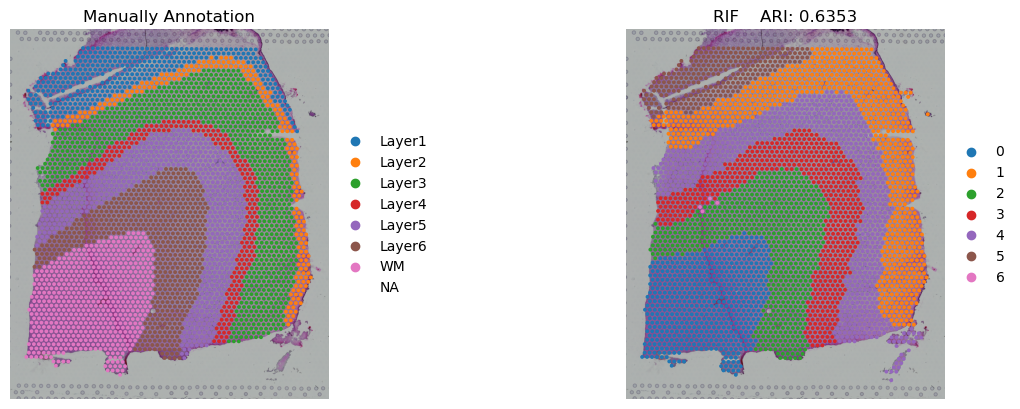

In [5]:
adata, new_key = Riff.test_refine(adata, num_classes, max_neigh=args.radius, key='combined', refined_key='combined_refine')
adata.obs[new_key] = adata.obs[new_key].astype(int).astype('category') 
adata_reduce = adata[~pd.isna(adata.obs['layer_guess'])]
ari = round(adjusted_rand_score(adata_reduce.obs['layer_guess'], adata_reduce.obs[new_key]), 4)
sc.pl.spatial(adata, color=['layer_guess', new_key], title=['Manually Annotation', 'RIF    ARI: '+str(ari)], 
              s=8, frameon=False)

# 3. UMAP and PAGA

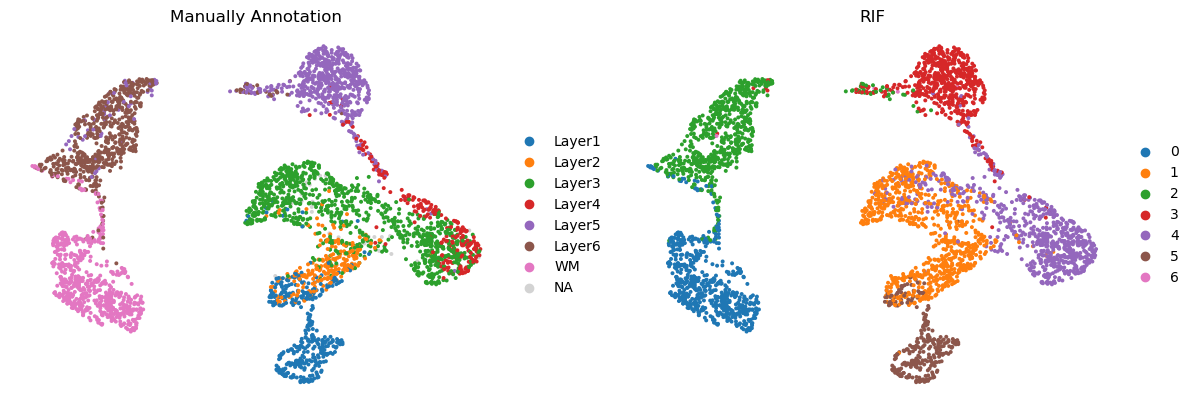

In [6]:
sc.pp.neighbors(adata, use_rep='Riff_embedding')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['layer_guess', new_key], title=['Manually Annotation', 'RIF'], frameon=False)

... storing 'subject' as categorical
... storing 'subject_position' as categorical
... storing 'Maynard' as categorical
... storing 'Martinowich' as categorical
... storing 'layer_guess_reordered' as categorical
... storing 'layer_guess_reordered_short' as categorical
... storing 'pred1_refine' as categorical
... storing 'pred2_refine' as categorical
... storing 'combined_refine' as categorical
... storing 'combined_refine_37' as categorical
... storing 'combined_refine_19' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


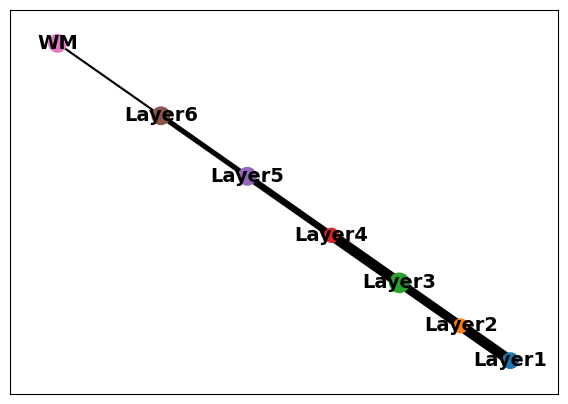

In [7]:
sc.pp.neighbors(adata_reduce, use_rep='Riff_embedding')
sc.tl.paga(adata_reduce, groups='layer_guess')
sc.pl.paga(adata_reduce, fontsize=14)

# 4. Save as .h5ad file for SVG detection

In [13]:
adata.write_h5ad(args.output_folder + '/adata/' + args.sample_name + '.h5ad')